# Zipline Backtest and Pyfolio Tearsheet

This notebook shows how to run a Zipline backtest using the QuantRocket client then analyze the backtests results inside the notebook using pyfolio.

In [1]:
from quantrocket.zipline import run_algorithm, ingest_bundle
import pandas as pd
import pyfolio as pf
import io

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


First, we'll ingest a bundle from a QuantRocket history database. (History database must already exist!)

In [2]:
ingest_bundle(history_db="etf-sampler-1d")

{'msg': 'successfully ingested etf-sampler-1d bundle', 'status': 'success'}

Next, run the backtest. QuantRocket returns the Zipline backtest results as a CSV. We write this CSV to an in-memory file then parse the file into a pandas DataFrame.

(Note that the backtest runs remotely on the zipline service, not inside the jupyter service, i.e. not in the notebook environment itself. QuantRocket's jupyter service doesn't support running Zipline backtests via the `%%zipline` extension.)

In [3]:
f = io.StringIO()
run_algorithm("momentum_pipeline.py", 
              bundle="etf-sampler-1d",
              start="2015-02-04", 
              end="2015-12-31",
              filepath_or_buffer=f)
results = pd.read_csv(f, index_col=["dataframe", "index", "column"])["value"]

The CSV result file returned by `run_algorithm` contains several DataFrames stacked into one: the Zipline performance results, plus the extracted returns, transactions, and positions from those results. We need to massage the returns, transactions, and positions back into the individual DataFrames (and data types) pyfolio expects.

In [4]:
# Extract returns
returns = results.loc["returns"].unstack()
returns.index = pd.to_datetime(returns["dt"], utc=True).dt.tz_localize("UTC")
returns = returns["returns"].astype(float)
# Extract positions
positions = results.loc["positions"].unstack()
positions.index = pd.to_datetime(positions["dt"], utc=True).dt.tz_localize("UTC")
positions = positions.drop("dt", axis=1).astype(float)
# Extract transactions
transactions = results.loc["transactions"].unstack()
transactions.index = pd.to_datetime(transactions["dt"], utc=True).dt.tz_localize("UTC")
transactions = transactions.drop("dt", axis=1).apply(pd.to_numeric, errors='ignore')

Now we can generate our pyfolio tearsheet.

Entire data start date: 2015-02-04
Entire data end date: 2015-12-31
Backtest months: 10


,Backtest
Annual return,33.4%
Cumulative returns,30.1%
Annual volatility,20.4%
Sharpe ratio,1.52
Calmar ratio,2.72
Stability,0.78
Max drawdown,-12.3%
Omega ratio,1.28
Sortino ratio,2.40
Skew,0.20


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.30,2015-08-05,2015-09-22,NaT,NaN
1,5.52,2015-03-17,2015-03-26,2015-04-01,12
2,3.79,2015-04-16,2015-05-06,2015-07-01,55
3,2.40,2015-07-27,2015-07-29,2015-08-03,6
4,2.33,2015-03-09,2015-03-11,2015-03-16,6


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


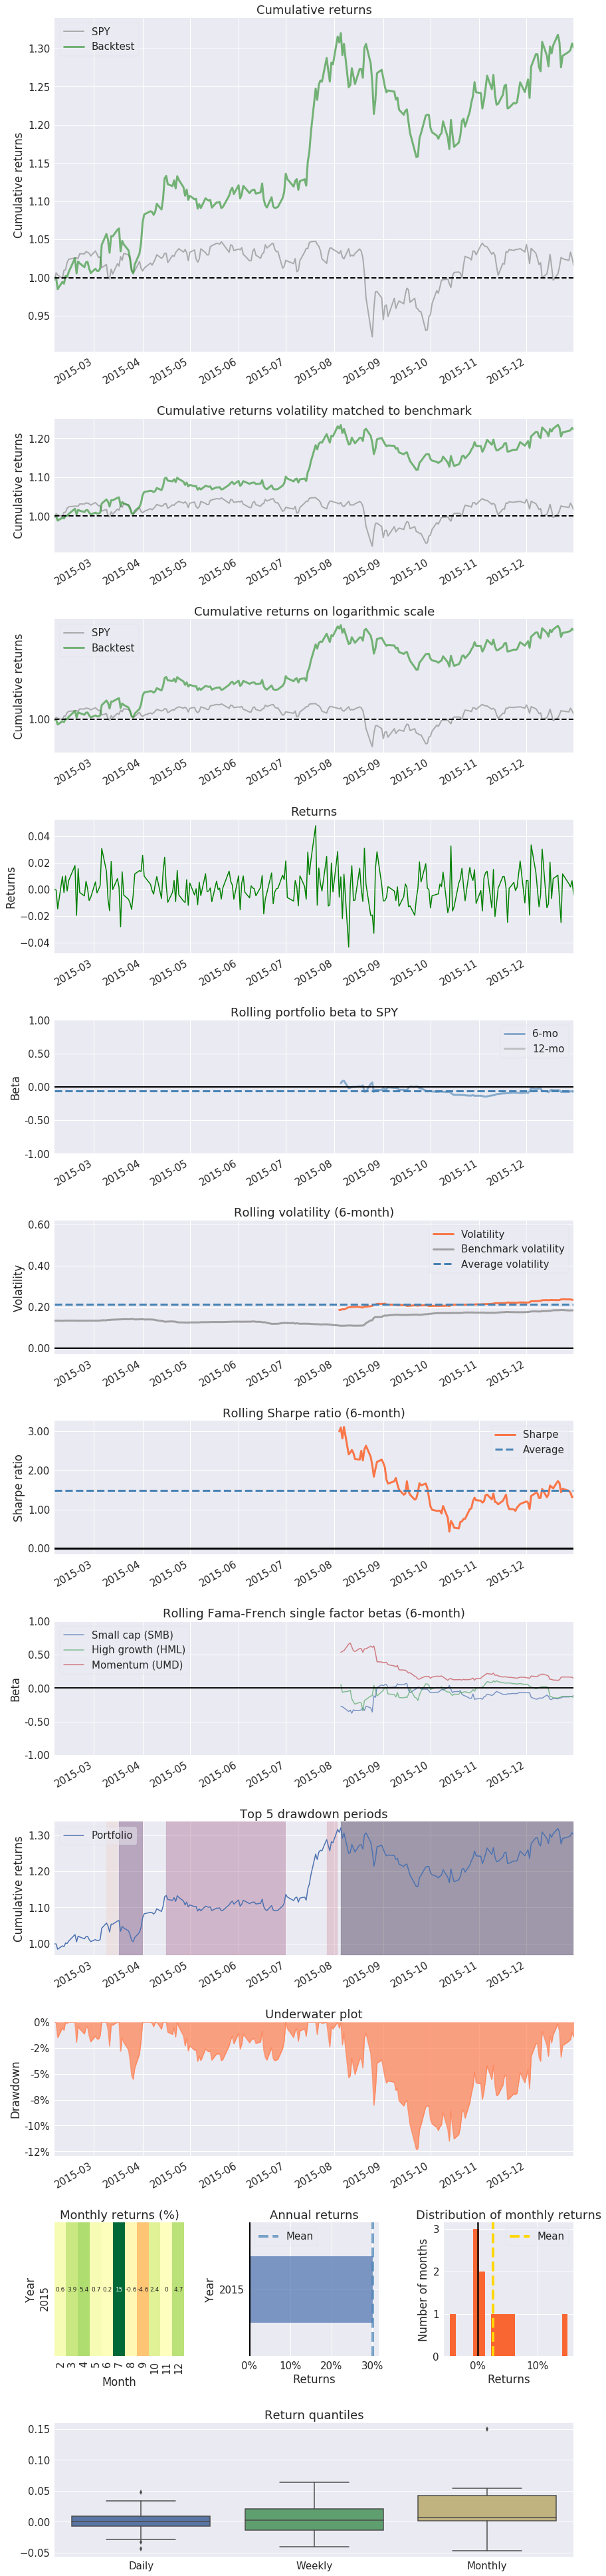

Stress Events,mean,min,max
Fall2015,-0.09%,-3.31%,3.09%
New Normal,0.12%,-4.34%,4.79%


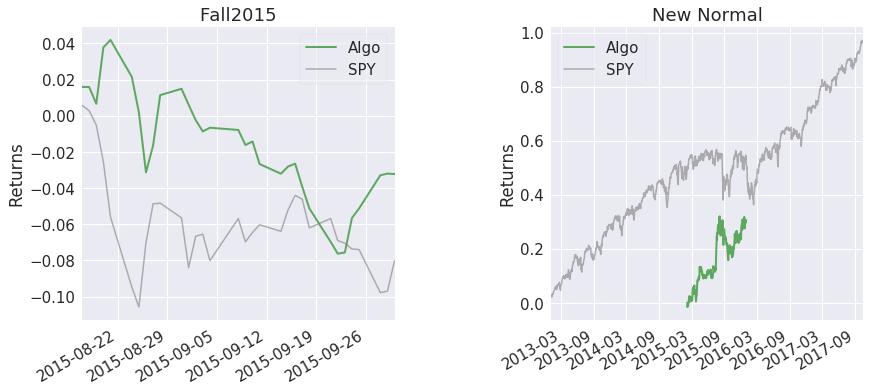

Top 10 long positions of all time,max
column,
Equity(31230302 [VNQ]),66.03%
Equity(45540782 [XOP]),49.21%
Equity(229726316 [GDX]),41.17%
Equity(4215220 [XLF]),35.18%
Equity(6604766 [EEM]),34.71%
Equity(756733 [SPY]),34.71%


Top 10 short positions of all time,max
column,
Equity(45540782 [XOP]),-75.69%
Equity(31230302 [VNQ]),-53.99%
Equity(229726316 [GDX]),-43.17%
Equity(756733 [SPY]),-35.80%
Equity(4215220 [XLF]),-35.78%
Equity(6604766 [EEM]),-35.61%


Top 10 positions of all time,max
column,
Equity(45540782 [XOP]),75.69%
Equity(31230302 [VNQ]),66.03%
Equity(229726316 [GDX]),43.17%
Equity(756733 [SPY]),35.80%
Equity(4215220 [XLF]),35.78%
Equity(6604766 [EEM]),35.61%


All positions ever held,max
column,
Equity(45540782 [XOP]),75.69%
Equity(31230302 [VNQ]),66.03%
Equity(229726316 [GDX]),43.17%
Equity(756733 [SPY]),35.80%
Equity(4215220 [XLF]),35.78%
Equity(6604766 [EEM]),35.61%


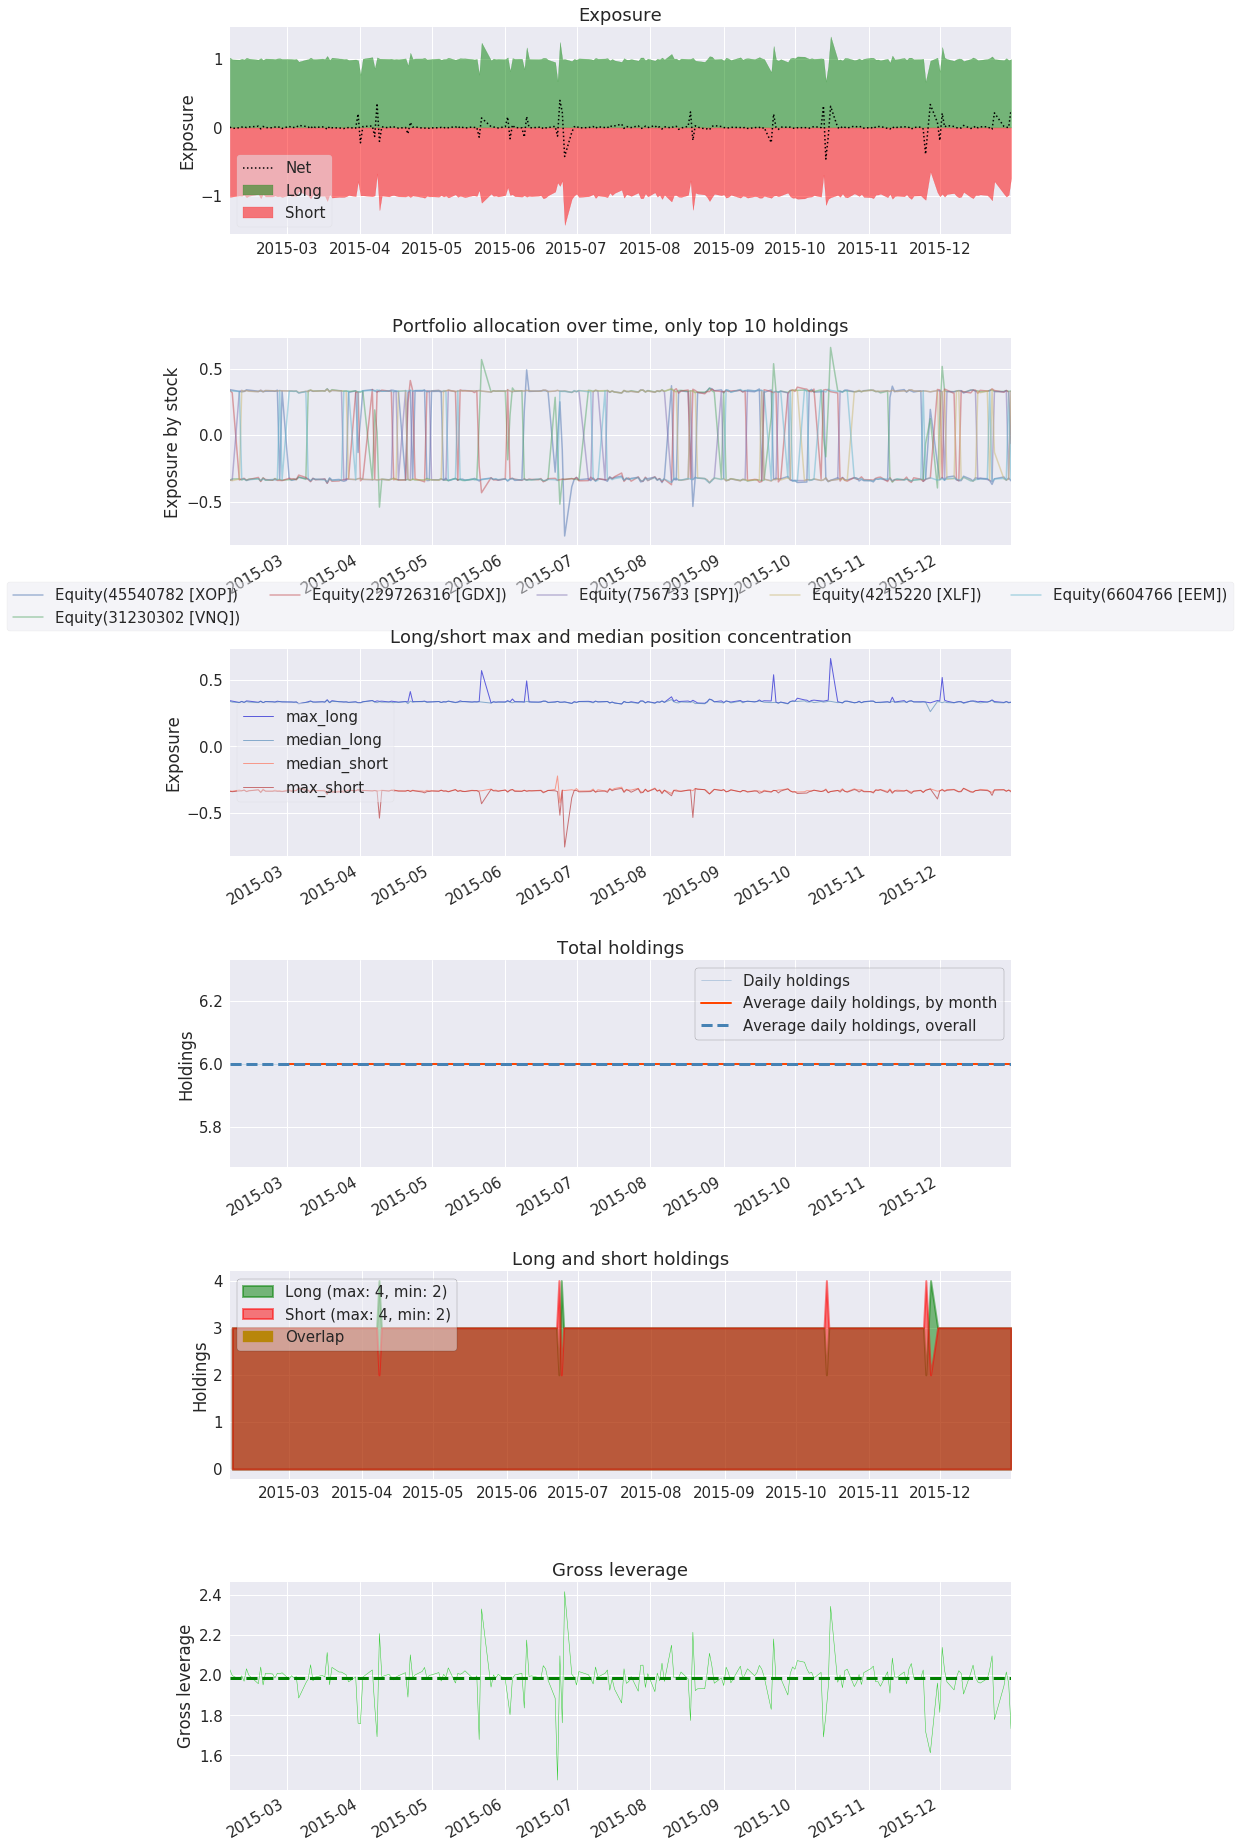

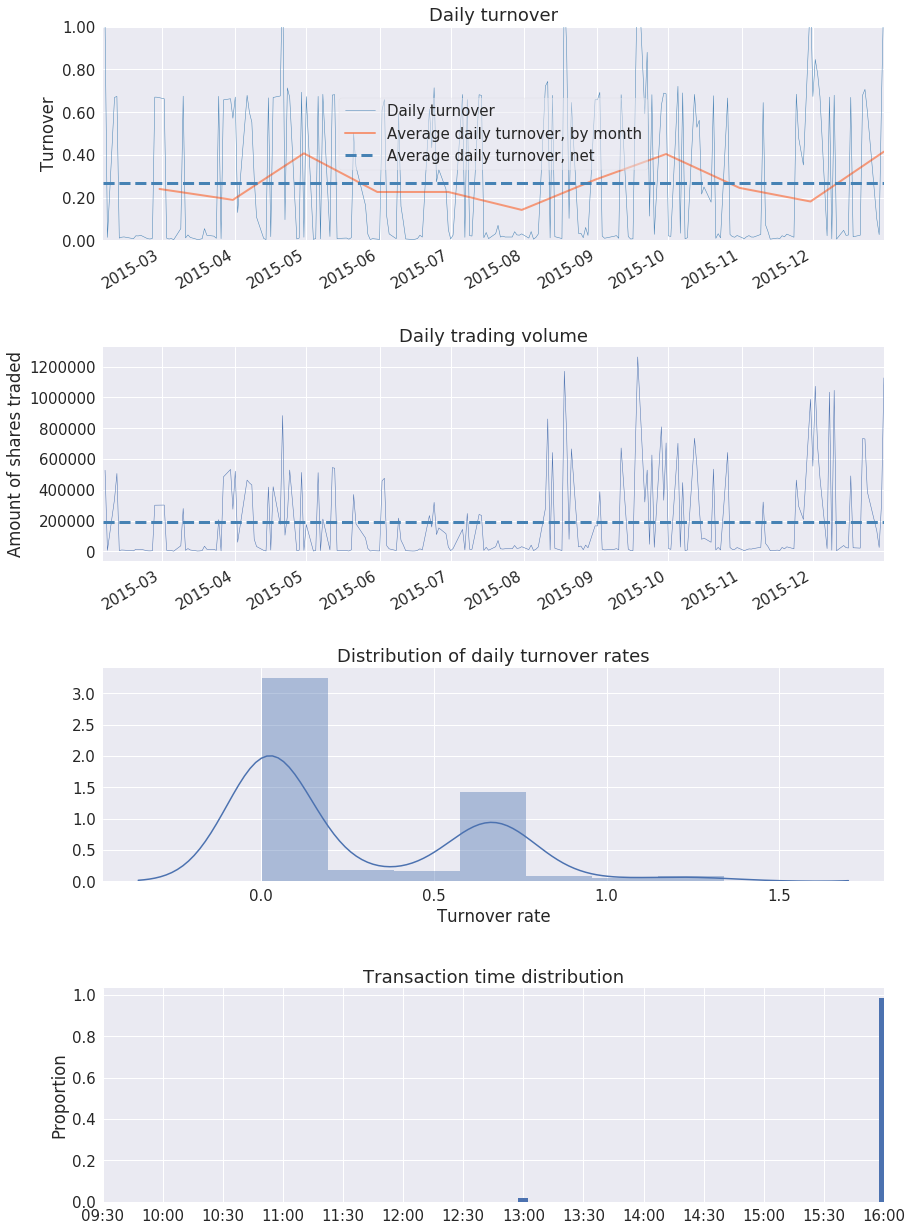

In [5]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions)

If you want to explore the Zipline backtest results directly, you can do that as well. 

In [6]:
perf = results.loc["perf"].unstack()
perf.index = pd.to_datetime(perf["dt"], utc=True).dt.tz_localize("UTC")
perf = perf.drop("dt", axis=1).apply(pd.to_numeric, errors='ignore')
print(perf.head())

column                     algo_volatility  algorithm_period_return     alpha  \
dt                                                                              
2015-02-04 00:00:00+00:00              NaN                 0.000000       NaN   
2015-02-05 00:00:00+00:00         0.004567                -0.000407 -0.028079   
2015-02-06 00:00:00+00:00         0.132510                -0.015058 -1.398855   
2015-02-09 00:00:00+00:00         0.158897                -0.005563 -0.345052   
2015-02-10 00:00:00+00:00         0.137807                -0.007946 -0.359151   

column                     benchmark_period_return  benchmark_volatility  \
dt                                                                         
2015-02-04 00:00:00+00:00                -0.003808                   NaN   
2015-02-05 00:00:00+00:00                 0.006249              0.156060   
2015-02-06 00:00:00+00:00                 0.003466              0.122924   
2015-02-09 00:00:00+00:00                -0.001025  